# Домашнее задание. Решение задачи регрессии с помощью градиентного бустинга
В этом домашнем задании вы примените алгоритм градиентного бустинга к задаче регрессии. Мы будем решать задачу предсказания популярности трека на музыкальной платформе по различным характеристикам (имя музыканта, продолжительность, а также численные характеристика трека, такие как размер, громкость, лад (минор/мажор), энергичность, акустичность и т.д.

## Почему именно градиентный бустинг?
Обычно градиентный бустинг дает в стандартных задачах машинного обучения на табличных данных умеренный прирост по сравнению со случайным лесом: несколько процентных пунктов целевой метрики. В предлагаемой вам задаче все иначе: градиентный бустинг в библиотеке `CatBoost` здесь дает по сравнению с бейзлайном **четырехкратный** прирост по метрике $R^2$. Помимо самого алгоритма бустинга, это связано со способностью `CatBoost` качественно кодировать категориальные признаки, тогда как стандартные модели машинного обучения в `sklearn` (как и альтернативные реализации градиентного бустинга) по умолчанию этого делать не умеют. При выполнении домашнего задания вам предстоит в этом убедиться.

## Данные и посылка
в этом задании мы будем проверять и оценивать вашу посылку так, как это происходит на конкурсах по машинному обучению (например, на платформе kaggle.com). Для этого мы предварительно разделили данные в задании на две части.

1. data_train.csv. В каждой строчке файла data_train.csv содержатся следующие поля:
* `track_id` --- уникальный ключ, который мы будем использовать в качестве `pd.Index`
* `artist_name` --- имя исполнителя (важный категориальный признак, качественное использование которого кратно повышает качество модели)
* `track_name` --- название трека. Это поле не используется в базовом решении и в авторском решении, но никто не мешает вам попробовать его использовать
* `acousticness` --- числовой признак
* `danceability` --- числовой признак
* `duration_ms` --- числовой признак
* `energy` --- числовой признак
* `instrumentalness` --- числовой признак
* `key` --- категориальный признак
* `liveliness` --- числовой признак
* `loudness` --- числовой признак
* `mode` --- бинарный признак
* `speechiness`	--- числовой признак
* `tempo` --- числовой признак
* `time_signature` --- категориальный признак
* `valence` --- числовой признак
* `popularity` --- целевая переменная, принимающая целое значение от 1 до 100.

На этом наборе данных вам необходимо создать и обучить модель.

2. data_scoring.csv. В каждой строчке файла data_scoring.csv указаны признаки тестовых объектов. Предсказания для этого набора необходимо записать в файл submission.csv и сдать в соответствующий шаг на Stepik. Количество попыток ограничено 100 штук.
Также мы предоставляем файл [sample_submission.csv](https://drive.google.com/file/d/1QlQnKFOej3hg5tNcjx4DRrd6QPNdTl_7/view?usp=share_link). Это образец посылки --- ваш файл submission.csv должен быть оформлен таким же образом. Обратите внимание, что порядок строчек в submission должен быть такой же, как и в data_scoring.csv!

## Целевая метрика
Целевая метрика в этой задаче --- $R^2$. Именно по ней система будет выставлять вам баллы. Минимальное значение $R^2$, за которое ставятся баллы, равно $lb=0.450$. Чтобы набрать полный балл за задание, необходимо набрать $ub=0.475$.
Оценка выставляется по формуле
$$\begin{cases}
0, & score \leqslant lb,\\
10 \cdot \frac{score - lb}{ub - lb}, & lb < score < ub,\\
10, & score \geqslant ub.
\end{cases}$$

## Бейзлайн
В этом ноутбуке приведен бейзлайн на основе случайного леса, который оценивается в 0 баллов на Stepik (дает $R^2=0.15$).

## Ход работы
Для получения необходимого качества предлагаем использовать модель `catboost.CatBoostRegressor`. Эта модель с любыми параметрами скорее всего принесет вам какие-то баллы за задание. При этом максимальный балл принесет модель, у которой подобран оптимальный параметр глубины. Для нахождения этого параметра мы предлагаем использовать кросс-валидацию, встроенную в `catboost`.

Обратите внимание, что кодирование категориальных признаков, принятое по умолчанию в `catboost`, работает лучше, чем выделение числовых признаков с помощью One-hot Encoding. Поэтому вам этот этап обработки данных не понадобится, хотя он и реализован в бейзлайне. Для того, чтобы указать `catboost`, какие данные являются категориальными, необходимо использовать параметр `cat_features` при создании `catboost.Pool`.

Желаем удачи!

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

%matplotlib inline

In [ ]:
!pip install catboost # Не будем использовать в этом ноутбуке
!pip install scikit-learn==1.2 # Новая версия One-hot encoding доступна только в sklearn 1.2

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestRegressor

Скачиваем данные

In [ ]:
!gdown 1G-dH-66bWsl16RC9n8AX4370I2LRkgzO  # data_train.csv
!gdown 1pVrpyO5ZxouaDGYW29L0mWUnognmiZIq  # data_scoring.csv

In [4]:
data = pd.read_csv('data_train.csv', index_col='track_id')
data.head()

,artist_name,track_name,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,popularity
track_id,,,,,,,,,,,,,,,,
77WL0prmlUqQ3Uv2H7X8Tv,Houzemaster,My Way,0.0775,0.703,199523,0.271,0.834000,6,0.1080,-14.608,0,0.0744,120.007,4,0.7000,0
5QTxCUGrKdbxEWKedcF7Ty,Magnus Foss,Doesn't Matter,0.0546,0.759,198000,0.567,0.870000,1,0.0838,-10.655,1,0.0444,120.006,4,0.0969,0
7rreyET2avyDiKloE6fjBg,Giriboy,BangBup,0.1420,0.555,167584,0.828,0.000000,1,0.3360,-3.555,1,0.3830,74.954,4,0.6220,15
0yLrdldrWbq8U4A5ilvF6g,Kip Moore,Love You To The Moon,0.3160,0.745,223880,0.640,0.000007,7,0.0804,-6.095,1,0.0342,101.025,4,0.8990,50
12PL3IiJsrN5254htzLWRO,Bobina,The Reason,0.1860,0.513,189600,0.818,0.000000,3,0.1040,-3.693,1,0.0332,99.972,4,0.2160,11


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 65163 entries, 77WL0prmlUqQ3Uv2H7X8Tv to 1r1pHmMcW1mzdYNFi1Zqb6
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   artist_name       65163 non-null  object 
 1   track_name        65163 non-null  object 
 2   acousticness      65163 non-null  float64
 3   danceability      65163 non-null  float64
 4   duration_ms       65163 non-null  int64  
 5   energy            65163 non-null  float64
 6   instrumentalness  65163 non-null  float64
 7   key               65163 non-null  int64  
 8   liveness          65163 non-null  float64
 9   loudness          65163 non-null  float64
 10  mode              65163 non-null  int64  
 11  speechiness       65163 non-null  float64
 12  tempo             65163 non-null  float64
 13  time_signature    65163 non-null  int64  
 14  valence           65163 non-null  float64
 15  popularity        65163 non-null  int64  
dtypes: floa

Разбиваем на train и test

In [6]:
X_train, X_test, y_train, y_test = train_test_split(
    data.drop(columns=['popularity']),
    data['popularity'], test_size=0.2)

cat_features = ['artist_name', 'track_name']

# Воспользуемся CatBoost

In [7]:
from catboost import CatBoostRegressor, Pool, cv


train_dataset = Pool(data=X_train,
                     label=y_train,
                     cat_features=cat_features)

test_dataset = Pool(data=X_test,
                     label=y_test,
                     cat_features=cat_features)

In [ ]:
depth = 10

params = {
    "iterations": 760,
    "depth": depth,
    "loss_function": "RMSE",
    "custom_metric": ["R2"],
    "verbose": False
}

scores = cv(train_dataset,
           params,
           fold_count=5)

scores

Training on fold [0/5]

bestTest = 14.27064218
bestIteration = 574

Training on fold [1/5]

bestTest = 14.47408731
bestIteration = 694

Training on fold [2/5]

bestTest = 14.50964167
bestIteration = 493

Training on fold [3/5]

bestTest = 14.28208574
bestIteration = 600

Training on fold [4/5]

bestTest = 14.21065029
bestIteration = 621



,iterations,test-RMSE-mean,test-RMSE-std,train-RMSE-mean,train-RMSE-std,test-R2-mean,test-R2-std,train-R2-mean,train-R2-std
0,0,30.626124,0.290523,30.625043,0.070733,-1.411038,0.007193,-1.410499,0.001621
1,1,30.065756,0.290815,30.064203,0.069090,-1.323610,0.007594,-1.323020,0.001550
2,2,29.532198,0.291161,29.528404,0.066706,-1.241866,0.008176,-1.240957,0.001338
3,3,29.019422,0.290215,29.012658,0.065838,-1.164686,0.008371,-1.163359,0.001381
4,4,28.530600,0.290977,28.518576,0.063887,-1.092369,0.008823,-1.090303,0.001300
...,...,...,...,...,...,...,...,...,...
755,755,14.356053,0.134143,13.385637,0.054811,0.470206,0.005353,0.539498,0.002268
756,756,14.355937,0.134031,13.383370,0.055583,0.470214,0.005356,0.539654,0.002315
757,757,14.355789,0.133964,13.380551,0.056093,0.470225,0.005349,0.539848,0.002338
758,758,14.356024,0.133940,13.377886,0.055743,0.470208,0.005351,0.540031,0.002298


In [ ]:
scores['test-R2-mean'].values[-1]

0.47022002986329514

In [ ]:
depths = np.arange(7, 11)
boosting_metrics = []

for depth in depths:
    params = {
        "iterations": 760,
        "depth": depth,
        "loss_function": "RMSE",
        "custom_metric": ["R2"],
        "verbose": False
    }

    scores = cv(train_dataset,
              params,
              fold_count=5)

    boosting_metrics.append(max(scores['test-R2-mean'].values))

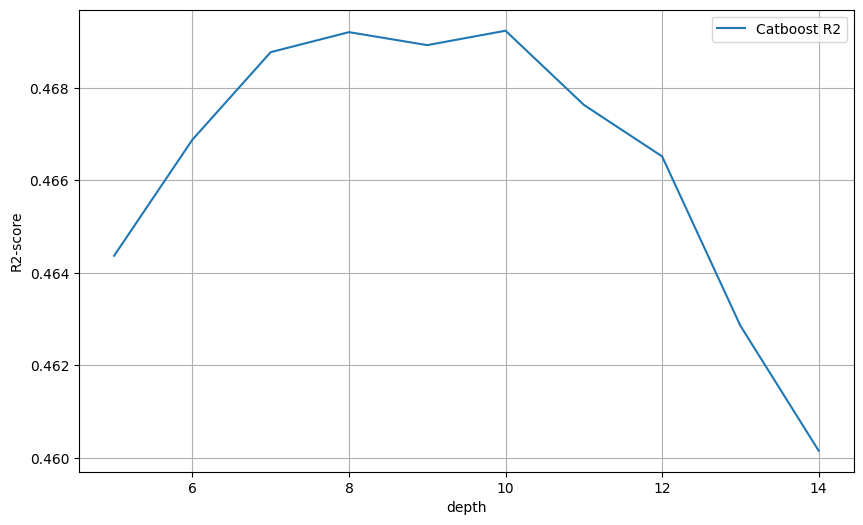

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(depths, boosting_metrics, label="Catboost R2")
plt.xlabel("depth")
plt.ylabel("R2-score")
plt.grid()
plt.legend()
plt.show()

In [8]:
best_depth = 8

cb = CatBoostRegressor(iterations=760, depth=best_depth, loss_function="RMSE", verbose=False)
cb.fit(train_dataset)

In [9]:
train_y_pred_boosting = cb.predict(train_dataset)
test_y_pred_boosting = cb.predict(test_dataset)

In [10]:
from sklearn.metrics import r2_score


print(f"R2-score-train: {r2_score(y_train, train_y_pred_boosting)}")
print(f"R2-score-test: {r2_score(y_test, test_y_pred_boosting)}")

R2-score-train: 0.7501423303510184
R2-score-test: 0.48266279115828725


In [11]:
data_scoring = pd.read_csv('data_scoring.csv', index_col='track_id')
data_scoring.head()

,artist_name,track_name,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence
track_id,,,,,,,,,,,,,,,
6D8WgDaIuyirn6egGauzVK,RITUAL,Love Me Back,0.498,0.745,178233,0.664,0.000008,1,0.0777,-4.280,1,0.0613,108.067,4,0.468
7ywsuXRTQ9xNKhZSmSD3Q0,Dalton Mauldin,Nights Without You,0.221,0.539,157751,0.536,0.000000,5,0.4940,-8.722,1,0.0552,183.784,4,0.725
1eoGO19WEflJbAV8BLebhr,Pandrezz,Orion,0.805,0.684,152000,0.255,0.790000,10,0.0884,-9.381,0,0.0445,84.226,4,0.330
3G79AJm9H5lKnngSgBT21L,Mc Davi,Ela Tá Que Tá,0.128,0.750,206829,0.418,0.000000,0,0.1280,-10.011,1,0.0496,123.007,4,0.253
2htWos5rGxFWSfLTyvpymm,G-Eazy,But A Dream - Alex Lustig Remix,0.401,0.563,198058,0.633,0.000000,5,0.1090,-6.252,0,0.2700,156.000,4,0.306


In [24]:
data_scoring['track_name'].replace(np.nan, 'unknown', inplace=True)

data_scoring.isnull().sum()

artist_name         0
track_name          0
acousticness        0
danceability        0
duration_ms         0
energy              0
instrumentalness    0
key                 0
liveness            0
loudness            0
mode                0
speechiness         0
tempo               0
time_signature      0
valence             0
dtype: int64

In [25]:
scoring_dataset = Pool(data=data_scoring,
                     cat_features=cat_features)

In [26]:
y_scoring = cb.predict(scoring_dataset)

In [27]:
submission = pd.Series(y_scoring, index=data_scoring.index, name='popularity')
submission.head()

track_id
6D8WgDaIuyirn6egGauzVK    31.576271
7ywsuXRTQ9xNKhZSmSD3Q0    27.323896
1eoGO19WEflJbAV8BLebhr    41.669026
3G79AJm9H5lKnngSgBT21L    24.883559
2htWos5rGxFWSfLTyvpymm    52.562585
Name: popularity, dtype: float64

In [28]:
submission.to_csv('baseline_submission.csv')

Кодируем категориальные данные с помощью `sklearn.preprocessing.OneHotEncoder`. Формируем полный датасет с помощью `pd.concat`.

In [ ]:
encoder = OneHotEncoder(max_categories=30, sparse=False, handle_unknown='ignore')
train_cat_data = pd.DataFrame(encoder.fit_transform(X_train[cat_features[1:]]),
                              index=X_train.index,
                              columns=encoder.get_feature_names_out())

test_cat_data = pd.DataFrame(encoder.transform(X_test[cat_features[1:]]),
                             index=X_test.index,
                             columns=encoder.get_feature_names_out())

full_train_data = pd.concat([X_train.drop(columns=cat_features + ['track_name']),
                             train_cat_data],
                            axis='columns')
full_test_data = pd.concat([X_test.drop(columns=cat_features + ['track_name']),
                            test_cat_data],
                           axis='columns')

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Перебираем параметр `max_depth` у модели sklearn.ensemble.RandomForestRegressor. Считаем метрики на train, test.

In [ ]:
rf_metrics = []
for depth in tqdm(range(8, 17)):
    rf_model = RandomForestRegressor(n_estimators=100,
                                     max_depth=depth,
                                     n_jobs=-1).fit(
        full_train_data,
        y_train)
    rf_metrics.append({'train': r2_score(y_train, rf_model.predict(full_train_data)),
                       'test': r2_score(y_test, rf_model.predict(full_test_data))})

100%|██████████| 9/9 [05:14<00:00, 34.94s/it]


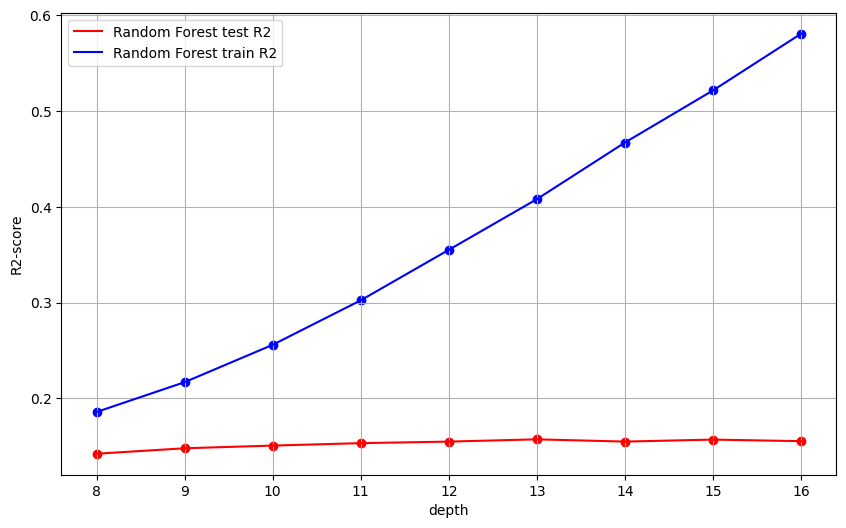

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(np.arange(8, 17),
         [item['test'] for item in rf_metrics],
         label='Random Forest test R2', color='red')
plt.scatter(np.arange(8, 17),
            [item['test'] for item in rf_metrics],
            color='red')

plt.plot(np.arange(8, 17),
         [item['train'] for item in rf_metrics],
         label='Random Forest train R2', color='blue')
plt.scatter(np.arange(8, 17),
            [item['train'] for item in rf_metrics],
            color='blue')

plt.xlabel('depth')
plt.ylabel('R2-score')
plt.grid()
plt.legend()

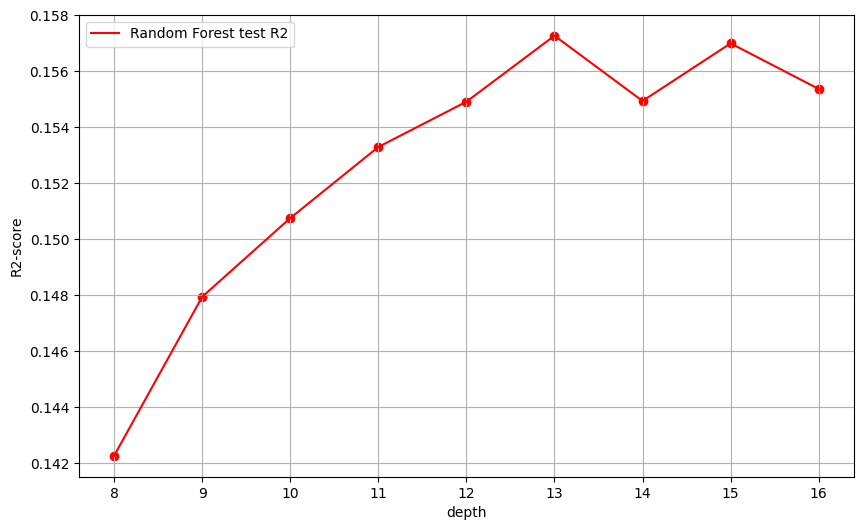

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(np.arange(8, 17),
         [item['test'] for item in rf_metrics],
         label='Random Forest test R2', color='red')
plt.scatter(np.arange(8, 17),
            [item['test'] for item in rf_metrics],
            color='red')

plt.xlabel('depth')
plt.ylabel('R2-score')
plt.grid()
plt.legend()

Оптимальный параметр глубины --- `max_depth=15`. Обучим окончательную модель, предскажем ответы на `data_scoring` и сформируем submission.

In [ ]:
data_scoring = pd.read_csv('data_scoring.csv', index_col='track_id')
data_scoring.head()

,artist_name,track_name,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence
track_id,,,,,,,,,,,,,,,
6D8WgDaIuyirn6egGauzVK,RITUAL,Love Me Back,0.498,0.745,178233,0.664,0.000008,1,0.0777,-4.280,1,0.0613,108.067,4,0.468
7ywsuXRTQ9xNKhZSmSD3Q0,Dalton Mauldin,Nights Without You,0.221,0.539,157751,0.536,0.000000,5,0.4940,-8.722,1,0.0552,183.784,4,0.725
1eoGO19WEflJbAV8BLebhr,Pandrezz,Orion,0.805,0.684,152000,0.255,0.790000,10,0.0884,-9.381,0,0.0445,84.226,4,0.330
3G79AJm9H5lKnngSgBT21L,Mc Davi,Ela Tá Que Tá,0.128,0.750,206829,0.418,0.000000,0,0.1280,-10.011,1,0.0496,123.007,4,0.253
2htWos5rGxFWSfLTyvpymm,G-Eazy,But A Dream - Alex Lustig Remix,0.401,0.563,198058,0.633,0.000000,5,0.1090,-6.252,0,0.2700,156.000,4,0.306


In [ ]:
scoring_cat_data = pd.DataFrame(encoder.fit_transform(data_scoring[cat_features[1:]]),
                              index=data_scoring.index,
                              columns=encoder.get_feature_names_out())

full_scoring_data = pd.concat([data_scoring.drop(columns=cat_features + ['track_name']),
                             scoring_cat_data],
                            axis='columns')

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [ ]:
model = RandomForestRegressor(max_depth=15)
model.fit(full_train_data, y_train)

y_scoring = np.clip(model.predict(full_scoring_data), 0, 100)

ValueError: Found input variables with inconsistent numbers of samples: [48872, 52130]

In [ ]:
submission = pd.Series(y_scoring, index=data_scoring.index, name='popularity')
submission.head()

track_id
6D8WgDaIuyirn6egGauzVK    35.103139
7ywsuXRTQ9xNKhZSmSD3Q0    25.749885
1eoGO19WEflJbAV8BLebhr    36.373913
3G79AJm9H5lKnngSgBT21L    23.809317
2htWos5rGxFWSfLTyvpymm    30.638233
Name: popularity, dtype: float64

Обратите внимание, что порядок строчек в submission должен быть такой же, как и в data_scoring.csv!

In [ ]:
submission.to_csv('baseline_submission.csv')